**Table of contents**<a id='toc0_'></a>    
1. [Datenpreprozessierung](#toc1_)    
1.1. [Dataframes laden und auf wöchentlich aggregieren](#toc1_1_)    
1.2. [Transformieren](#toc1_2_)    
1.3. [Splitten](#toc1_3_)    
2. [Feature Selection](#toc2_)    
2.1. [per Korrelation](#toc2_1_)    
2.2. [per RandomForestRegressor](#toc2_2_)    
2.3. [Recursive Feature Elimination (RFE)](#toc2_3_)    
2.4. [Final Features](#toc2_4_)    
3. [Auswahl des Machine Learning Moduls](#toc3_)    
3.1. [Average Modell](#toc3_1_)    
3.2. [Linear Regression](#toc3_2_)    
3.3. [Linear Regression Regularized Model - LASSO](#toc3_3_)    
3.4. [Linear Regression Regularized Model - Ridge](#toc3_4_)    
3.5. [k nearest neighbor (KNN)](#toc3_5_)    
3.6. [Suport Vector Machines (SVM)](#toc3_6_)    
3.7. [Random Forest Regressor](#toc3_7_)    
3.8. [MLP Regressor (deep-Learning)](#toc3_8_)    
4. [CrossValidation und HyperParameter Tuning](#toc4_)    
4.1. [Cross Validation](#toc4_1_)    
4.2. [Hyperparameter Tuning](#toc4_2_)    
4.3. [Paramater auf Overfitting testen](#toc4_3_)    
5. [ZukunftsDataframe erstellen](#toc5_)    
5.1. [Datenskelett aufbauen (letzen 8 Wochen der Daten)](#toc5_1_)    
5.2. [Datenskelett testen](#toc5_2_)    
6. [Finales Modell und Zukunft](#toc6_)    
6.1. [Datenskelett aufbauen (zukunft)](#toc6_1_)    
6.2. [Zukunft vorhersagen](#toc6_2_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=1
	maxLevel=4
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import time

#plotten
import matplotlib.pyplot as plt
import seaborn as sns

#Plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
%matplotlib inline
import kaleido

from IPython.display import display, HTML
from functools import reduce
import joblib
import pyarrow as pa
from scipy.stats import anderson, randint, ttest_ind
pd.set_option('display.max_columns', None)

# machine Learning
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.feature_selection import SelectPercentile, f_regression, RFE, SelectFromModel
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, KFold, train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, make_scorer
from sklearn.preprocessing import PowerTransformer, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer

# 1. <a id='toc1_'></a>Datenpreprozessierung [&#9650;](#toc0_)

## 1.1. <a id='toc1_1_'></a>Dataframes laden und auf wöchentlich aggregieren [&#9650;](#toc0_)

In [ ]:
# Dataframes laden
df_daily = pd.read_parquet("..\\Save_files\\df_daily.parquet", engine='pyarrow')
df_agg = pd.read_parquet("..\\Save_files\\df_agg.parquet", engine='pyarrow')


Zunächst die Daten auf wöchentliche Ebene aggregieren um Datenmenge zu reduzieren

In [ ]:
df_weekly = df_daily.copy()
df_weekly.set_index("Datum", inplace=True)
# Listen mit Spaltennamen für Aggregationsfunktion erstellen 
to_sum = ['Umsatz', 'Kundenzahl', 'Geöffnet',
          'Promo', 'ist_Promo2', 'Schulferien', 
          'Ostern', 'Weihnachten', 'öffentl_Feiertag',
          'regulärer_Tag', "Sonntag"]

# zweite Liste für Aggregationsfunktion
to_last = ['Geschäftstyp', 'Sortiment', "Bundesland", "Gruppe",
           'Wettbew_Distanz', 'Wettbew_seit_Monaten',
           'Wettbew_offen_seit_Monat', 'Wettbew_offen_seit_Jahr',
           'Promo2', 'Promo2_Intervall', 'Promo2_seit_Wochen', 
           'Promo2_seit_Woche','Promo2_seit_Jahr',
           'Jahr', 'Quartal', 'Monat', 'Kalenderwoche']

# Aggregationsfunktionen für die Spalten
agg_funcs = {col: 'sum' for col in to_sum}
agg_funcs.update({col: 'last' for col in to_last})

df_weekly = df_weekly.groupby("Filiale").resample("W").agg(agg_funcs).reset_index()
df_weekly.dropna(inplace=True)

## 1.2. <a id='toc1_2_'></a>Transformieren [&#9650;](#toc0_)

In [ ]:
df = df_weekly.copy().reset_index(drop=True)

# Zielvariable Umsatz logarithmieren
df.Umsatz = np.log(df.Umsatz)

# kategorische Variable Gruppe in numerisch umwandeln
df['Gruppe'] = df['Gruppe'].cat.codes

# OneHot Kodierung für ['Geschäftstyp', 'Sortiment', 'Bundesland']
to_encode = ['Geschäftstyp', 'Sortiment', 'Bundesland']
ohe = OneHotEncoder(sparse_output=False)
ohe.fit(df[to_encode].astype("str"))
# Für df
enc_columns = ohe.transform(df[to_encode].astype("str"))
# Dataframe with encoded columns
encoded_df = pd.DataFrame(enc_columns,
                        columns=ohe.get_feature_names_out(to_encode))
# adding encoded columns to train
df = pd.concat([df, encoded_df], axis=1).drop(columns=to_encode, axis=1)

# temporale Angaben zyklisieren
to_cyclic = ["Quartal", "Monat", "Kalenderwoche", "Jahr"]
# Quartal
df['Quartal_sin'] = df['Quartal'].apply(lambda x: np.sin(x*(2*np.pi/4)))
df['Quartal_cos'] = df['Quartal'].apply(lambda x: np.cos(x*(2*np.pi/4)))
# Monat
df['Monat_sin'] = df['Monat'].apply(lambda x: np.sin(x*(2*np.pi/12)))
df['Monat_cos'] = df['Monat'].apply(lambda x: np.cos(x*(2*np.pi/12)))
# Kalenderwoche (W)
df['Kalenderwoche_sin'] = df['Kalenderwoche'].apply(lambda x: np.sin(x*(2*np.pi/52)))
df['Kalenderwoche_cos'] = df['Kalenderwoche'].apply(lambda x: np.cos(x*(2*np.pi/52)))
# Jahr
df['Jahr_sin'] = df['Jahr'].apply(lambda x: np.sin(x*(2*np.pi/365)))
df['Jahr_cos'] = df['Jahr'].apply(lambda x: np.cos(x*(2*np.pi/365)))

# zu löschen
df.drop(columns=["Promo2_Intervall", "Kundenzahl"], inplace=True)
df.sort_values(["Datum", "Filiale"], inplace=True)

## 1.3. <a id='toc1_3_'></a>Splitten [&#9650;](#toc0_)

In [ ]:
print(f"Datum min {df.Datum.min()}")
print(f"Datum max {df.Datum.max()}")

Datum min 2013-01-06 00:00:00
Datum max 2015-08-02 00:00:00


In [ ]:
# Splitten
timestamp = pd.Timestamp(df["Datum"].sort_values().iloc[-1])
split_point = timestamp - pd.Timedelta(days=(7*8))
df_train_valid = df[df["Datum"] < split_point].reset_index(drop=True).copy()
df_test = df[df["Datum"] >= split_point].reset_index(drop=True).copy()

print(f"Train_Valid Datum min {df_train_valid.Datum.min()}")
print(f"Train_Valid Datum max {df_train_valid.Datum.max()}")
print(f"Test Datum min {df_test.Datum.min()}")
print(f"Test Datum max {df_test.Datum.max()}")

Train_Valid Datum min 2013-01-06 00:00:00
Train_Valid Datum max 2015-05-31 00:00:00
Test Datum min 2015-06-07 00:00:00
Test Datum max 2015-08-02 00:00:00


Split-Punkt des Datensatzes für test und train_valid

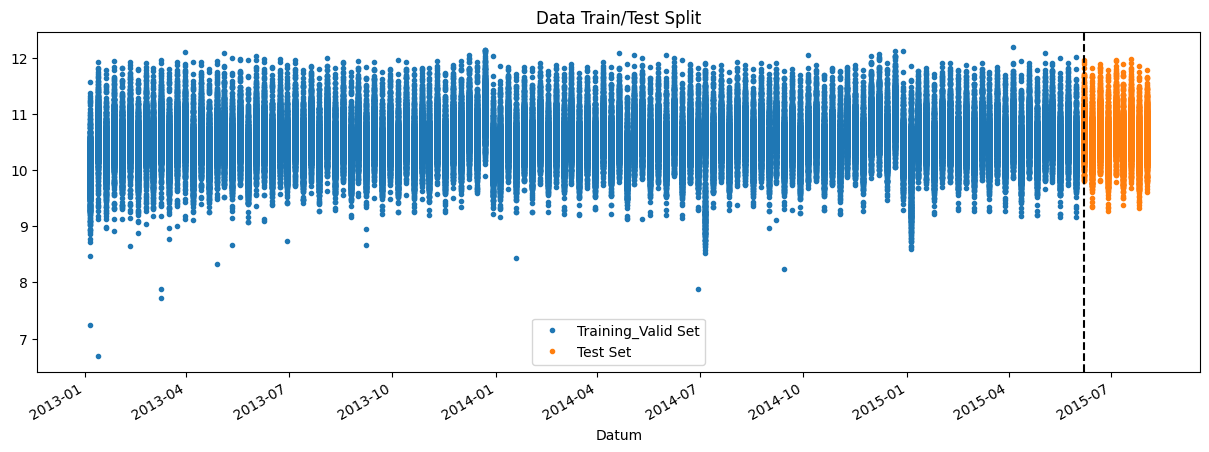

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
df_train_valid.sort_values(["Umsatz","Datum"]).plot(ax=ax, x="Datum", y="Umsatz", label="Training Set", title="Data Train/Test Split", style=".")
df_test.sort_values(["Umsatz","Datum"]).plot(ax=ax, x="Datum", y="Umsatz", label="Test Set", style=".")
ax.axvline(split_point, color="black", ls="--")
ax.legend(["Training_Valid Set", "Test Set"])
plt.show()

df_train_valid in ebenfalls splitten

In [ ]:
# Splitten
timestamp = pd.Timestamp(df_train_valid["Datum"].sort_values().iloc[-1])
split_point = timestamp - pd.Timedelta(days=(7*8))
df_train = df_train_valid[df_train_valid["Datum"] < split_point].reset_index(drop=True).copy()
df_valid = df_train_valid[df_train_valid["Datum"] >= split_point].reset_index(drop=True).copy()

print(f"Train Datum min {df_train.Datum.min()}")
print(f"Train Datum max {df_train.Datum.max()}")
print(f"Valid Datum min {df_valid.Datum.min()}")
print(f"Valid Datum max {df_valid.Datum.max()}")

Train Datum min 2013-01-06 00:00:00
Train Datum max 2015-03-29 00:00:00
Valid Datum min 2015-04-05 00:00:00
Valid Datum max 2015-05-31 00:00:00


Die Metriken zur Evaluation sind MAE, R2 und RMSE

In [ ]:
def metriken(y_test, y_pred):
    # Berechne die Metriken
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    return mae, r2, rmse

Testen eines simplen Random Forest Regressionsmodell mit df_train und df_valid

In [ ]:
# Train Daten
X_train = df_train.drop(["Umsatz", "Datum"], axis=1)
y_train = df_train['Umsatz']
# Test Daten
X_test = df_valid.drop(["Umsatz", "Datum"], axis=1)
y_test = df_valid['Umsatz']

rf = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)

# Vorhersage
y_pred = rf.predict(X_test)

# Metriken berechnen
mae, r2, rmse = metriken(y_test, y_pred)

results_transform = pd.DataFrame({"Features": ["alle"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})
results = results_transform
results

,Features,MAE,R2,RMSE
0,alle,0.067717,0.941124,0.091084


Im nächsten Schritt suchen wir die besten Features aus um Overfitting und Rechenzeit zu reduzieren. Bei den Features wird Kundenzahl gelöscht, da dies keine statische Information ist.

# 2. <a id='toc2_'></a>Feature Selection [&#9650;](#toc0_)

Hier werden mittels 3 Ansätzem Features rausgesucht und am Ende verglichen. 

## 2.1. <a id='toc2_1_'></a>per Korrelation [&#9650;](#toc0_)

In [ ]:
# Korrelation
df_corr=df.drop(columns=["Datum"]).corr()

# Korrelation berechnen für den Einfluss der Faktoren auf SalesPerDay
df_corr = round(df_corr["Umsatz"].sort_values().reset_index(), 2)
df_corr.columns = ["Feature", "Importance"]

# sortieren
df_corr = df_corr.sort_values(by="Importance", key=lambda x: abs(x), ascending=False)
# threshold von 0.1
df_corr = df_corr[df_corr.Importance.abs() >= 0.1]
np.array(df_corr.Feature)


array(['Umsatz', 'Gruppe', 'Promo', 'Geöffnet', 'regulärer_Tag',
       'Geschäftstyp_b', 'Sonntag', 'Promo2', 'Bundesland_Berlin',
       'Promo2_seit_Jahr', 'Sortiment_basic', 'Sortiment_extended'],
      dtype=object)

In [ ]:
features_korr = ['Gruppe', 'Promo', 'Geöffnet', 'regulärer_Tag',
       'Geschäftstyp_b', 'Sonntag', 'Bundesland_Berlin',
       'Promo2_seit_Jahr', 'Promo2', 'Sortiment_basic',
       'Sortiment_extended']

def features_testen(features_list, df_train, df_valid):
       # Train Daten
       X_train = df_train[features_list]
       y_train = df_train['Umsatz']
       # Test Daten
       X_test = df_valid[features_list]
       y_test = df_valid['Umsatz']
       rf = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)
       # Vorhersage
       y_pred = rf.predict(X_test)
       # Metriken berechnen
       mae, r2, rmse = metriken(y_test, y_pred)
       return mae, r2, rmse

mae, r2, rmse = features_testen(features_korr, df_train, df_valid)
results_korr = pd.DataFrame({"Features": ["Korrelation"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})
results = pd.concat([results_transform, results_korr])
results

,Features,MAE,R2,RMSE
0,alle,0.067717,0.941124,0.091084
0,Korrelation,0.126435,0.816456,0.160820


## 2.2. <a id='toc2_2_'></a>per RandomForestRegressor [&#9650;](#toc0_)

In [ ]:
# beste Features mit RandomForest
# Daten
# Train Daten
X_train = df_train.drop(["Umsatz", "Datum"], axis=1)
y_train = df_train['Umsatz']
# Test Daten
X_test = df_valid.drop(["Umsatz", "Datum"], axis=1)
y_test = df_valid['Umsatz']

# RandomForestRegressor-Modell

# SelectFromModel
select = SelectFromModel(RandomForestRegressor(n_jobs=-1, random_state=42), threshold="median")
select.fit(X_train, y_train)
# Transformieren
X_train_l1 = select.transform(X_train)
y_pred = select.transform(X_test)

# Wichtigkeit der Features
feature_importances = select.estimator_.feature_importances_
# Erstellen eines DataFrames mit den Feature-Namen und ihrer Wichtigkeit
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances}).sort_values(by='Importance', ascending=False)

# Anzeigen der ausgewählten Features
selected_features = feature_importance_df[feature_importance_df['Importance'] >= select.threshold_]
features_rf = selected_features.Feature.to_list()
np.array(features_rf)

array(['Gruppe', 'Promo', 'Bundesland_Bayern', 'Wettbew_Distanz',
       'Kalenderwoche', 'Filiale', 'Geöffnet', 'Wettbew_seit_Monaten',
       'Wettbew_offen_seit_Monat', 'Promo2_seit_Wochen', 'regulärer_Tag',
       'Wettbew_offen_seit_Jahr', 'Kalenderwoche_cos',
       'Promo2_seit_Woche', 'Kalenderwoche_sin', 'Monat', 'Monat_cos',
       'Promo2_seit_Jahr', 'Schulferien', 'Geschäftstyp_a',
       'Sortiment_basic', 'Bundesland_Berlin', 'Geschäftstyp_d',
       'Bundesland_NRW', 'Sortiment_extended'], dtype='<U24')

In [ ]:
features_rfr = ['Gruppe', 'Promo', 'Bundesland_Bayern', 'Wettbew_Distanz',
       'Kalenderwoche', 'Filiale', 'Geöffnet', 'Wettbew_seit_Monaten',
       'Wettbew_offen_seit_Monat', 'Promo2_seit_Wochen', 'regulärer_Tag',
       'Wettbew_offen_seit_Jahr', 'Kalenderwoche_cos',
       'Promo2_seit_Woche', 'Kalenderwoche_sin', 'Monat', 'Monat_cos',
       'Promo2_seit_Jahr', 'Schulferien', 'Geschäftstyp_a',
       'Sortiment_basic', 'Bundesland_Berlin', 'Geschäftstyp_d',
       'Bundesland_NRW', 'Sortiment_extended']

mae, r2, rmse = features_testen(features_rfr, df_train, df_valid)
results_rf = pd.DataFrame({"Features": ["RandomForestRegressor"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})
results = pd.concat([results, results_rf])
results

,Features,MAE,R2,RMSE
0,alle,0.067717,0.941124,0.091084
0,Korrelation,0.126435,0.816456,0.160820
0,RandomForestRegressor,0.067324,0.939668,0.092203


## 2.3. <a id='toc2_3_'></a>Recursive Feature Elimination (RFE) [&#9650;](#toc0_)

In [ ]:
# die slected features vom rfr werden noch mal gefitlert mit RFE, aber vorher löschen einiger Spalten
# zu löschen, "Geöffnet", "Schulferien", "regulärer Tag"
features_rfr = ['Gruppe', 'Promo', 'Bundesland_Bayern', 'Wettbew_Distanz',
       'Kalenderwoche', 'Filiale', 'Geöffnet', 'Wettbew_seit_Monaten',
       'Wettbew_offen_seit_Monat', 'Promo2_seit_Wochen', 'regulärer_Tag',
       'Wettbew_offen_seit_Jahr', 'Kalenderwoche_cos',
       'Promo2_seit_Woche', 'Kalenderwoche_sin', 'Monat', 'Monat_cos',
       'Promo2_seit_Jahr', 'Schulferien', 'Geschäftstyp_a',
       'Sortiment_basic', 'Bundesland_Berlin', 'Geschäftstyp_d',
       'Bundesland_NRW', 'Sortiment_extended']

# Train Daten
X_train = df_train[features_rfr]
y_train = df_train['Umsatz']
# Test Daten
X_test = df_valid[features_rfr]
y_test = df_valid['Umsatz']

# RFE fitten
select = RFE(RandomForestRegressor(n_jobs=-1, random_state=42, max_features="sqrt"))
select.fit(X_train, y_train)

X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

# Wichtigkeit der Features
feature_importances = select.estimator_.feature_importances_

# Erstellen eines DataFrames mit den Feature-Namen und ihrer Wichtigkeit
feature_names = X_train.columns[select.support_]
selected_features = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sortieren nach Wichtigkeit
selected_features = selected_features.sort_values(by='Importance', ascending=False)

# Anzeigen der ausgewählten Features
features_rfe = selected_features.Feature.to_list()
np.array(features_rfe)

array(['Gruppe', 'Promo', 'Wettbew_Distanz', 'Filiale', 'Kalenderwoche',
       'Wettbew_seit_Monaten', 'Geöffnet', 'Promo2_seit_Woche',
       'Wettbew_offen_seit_Monat', 'Wettbew_offen_seit_Jahr',
       'regulärer_Tag', 'Kalenderwoche_cos'], dtype='<U24')

In [ ]:
features_rfe = ['Gruppe', 'Promo', 'Wettbew_Distanz', 'Filiale', 'Kalenderwoche',
       'Wettbew_seit_Monaten', 'Wettbew_offen_seit_Monat',
       'Promo2_seit_Wochen', 'Promo2_seit_Woche',
       'Wettbew_offen_seit_Jahr', 'Kalenderwoche_cos']

mae, r2, rmse = features_testen(features_rfe, df_train, df_valid)
results_rfe = pd.DataFrame({"Features": ["Recursive Elimination"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})
results = pd.concat([results, results_rfe])
results

,Features,MAE,R2,RMSE
0,alle,0.067717,0.941124,0.091084
0,Korrelation,0.126435,0.816456,0.160820
0,RandomForestRegressor,0.067324,0.939668,0.092203
0,Recursive Elimination,0.070203,0.932944,0.097205


Das beste Ergebnis kommt RandomForestRegressor. Die features aus den rfr wurden weiter reduziert (löschen von "Geöffnet", "Schulferien", "regulärer Tag") und mit rfe noch mal reduziert.
Die Feature sind die ausgewählten Features

## 2.4. <a id='toc2_4_'></a>Final Features [&#9650;](#toc0_)

In [ ]:
selected_features= ['Gruppe', 'Promo', 'Wettbew_Distanz', 'Filiale', 'Kalenderwoche',
       'Wettbew_seit_Monaten', 'Wettbew_offen_seit_Monat',
       'Promo2_seit_Wochen', 'Promo2_seit_Woche',
       'Wettbew_offen_seit_Jahr', 'Kalenderwoche_cos']

# 3. <a id='toc3_'></a>Auswahl des Machine Learning Moduls [&#9650;](#toc0_)

In [ ]:
# Train Daten
X_train = df_train[selected_features]
y_train = df_train['Umsatz']
# Test Daten
X_test = df_valid[selected_features]
y_test = df_valid['Umsatz']

## 3.1. <a id='toc3_1_'></a>Average Modell [&#9650;](#toc0_)

In [ ]:
# Berechne den Durchschnitt der Trainingsdaten
mean_sales = np.mean(y_train)

# Verwende den Durchschnitt als Vorhersage für die Testdaten
y_pred = np.full_like(y_test, mean_sales)

# Metriken berechnen
mae, r2, rmse = metriken(y_test, y_pred)

results_avg = pd.DataFrame({"Model": ["Average"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})
results = results_avg
results

,Model,MAE,R2,RMSE
0,Average,0.297406,-0.004063,0.376141


## 3.2. <a id='toc3_2_'></a>Linear Regression [&#9650;](#toc0_)

In [ ]:
# model 
lr = LinearRegression().fit(X_train, y_train)

# prediction
y_pred = lr.predict(X_test)

# Metriken berechnen
mae, r2, rmse = metriken(y_test, y_pred)

results = pd.concat([results, pd.DataFrame({"Model": ["Linear Regression"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})])
results

,Model,MAE,R2,RMSE
0,Average,0.297406,-0.004063,0.376141
0,Linear Regression,0.136100,0.786306,0.173527


## 3.3. <a id='toc3_3_'></a>Linear Regression Regularized Model - LASSO [&#9650;](#toc0_)

In [ ]:
# model 
lasso = Lasso(alpha=0.1).fit(X_train, y_train)

# prediction
y_pred = lasso.predict(X_test)

# Metriken berechnen
mae, r2, rmse = metriken(y_test, y_pred)

results = pd.concat([results, pd.DataFrame({"Model": ["Lasso"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})])
results


,Model,MAE,R2,RMSE
0,Average,0.297406,-0.004063,0.376141
0,Linear Regression,0.136100,0.786306,0.173527
0,Lasso,0.165477,0.676529,0.213495


## 3.4. <a id='toc3_4_'></a>Linear Regression Regularized Model - Ridge [&#9650;](#toc0_)

In [ ]:
# model 
ridge = Ridge().fit(X_train, y_train)

# prediction
y_pred = ridge.predict(X_test)

# Metriken berechnen
mae, r2, rmse = metriken(y_test, y_pred)

results = pd.concat([results, pd.DataFrame({"Model": ["Ridge"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})])
results


,Model,MAE,R2,RMSE
0,Average,0.297406,-0.004063,0.376141
0,Linear Regression,0.136100,0.786306,0.173527
0,Lasso,0.165477,0.676529,0.213495
0,Ridge,0.136099,0.786306,0.173527


## 3.5. <a id='toc3_5_'></a>k nearest neighbor (KNN) [&#9650;](#toc0_)

In [ ]:
# Modell
knn = KNeighborsRegressor(n_neighbors=5).fit(X_train, y_train)

# Vorhersage
y_pred = knn.predict(X_test)

# Metriken berechnen
mae, r2, rmse = metriken(y_test, y_pred)

# Ergebnisse speichern
results = pd.concat([results, pd.DataFrame({"Model": ["K-Nearest Neighbors"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})])
results



,Model,MAE,R2,RMSE
0,Average,0.297406,-0.004063,0.376141
0,Linear Regression,0.136100,0.786306,0.173527
0,Lasso,0.165477,0.676529,0.213495
0,Ridge,0.136099,0.786306,0.173527
0,K-Nearest Neighbors,0.169748,0.746264,0.189087


## 3.6. <a id='toc3_6_'></a>Suport Vector Machines (SVM) [&#9650;](#toc0_)

Dieses Modul lädt zu lange weshalb es verworfen wird.

In [ ]:
# takes too long
# # Modell
# svm = SVR(kernel='linear').fit(X_train, y_train)

# # Vorhersage
# y_pred = svm.predict(X_test)

# # Metriken berechnen
# mae, r2, rmse = metriken(y_test, y_pred)

# # Ergebnisse speichern
# results = pd.concat([results, pd.DataFrame({"Model": ["Support Vector Machine"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})])

# results


## 3.7. <a id='toc3_7_'></a>Random Forest Regressor [&#9650;](#toc0_)

In [ ]:
# Modell
rf = RandomForestRegressor(n_jobs=-1).fit(X_train, y_train)

# Vorhersage
y_pred = rf.predict(X_test)

# Metriken berechnen
mae, r2, rmse = metriken(y_test, y_pred)

# Ergebnisse speichern
results = pd.concat([results, pd.DataFrame({"Model": ["Random Forest Regressor"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})])

results



,Model,MAE,R2,RMSE
0,Average,0.297406,-0.004063,0.376141
0,Linear Regression,0.136100,0.786306,0.173527
0,Lasso,0.165477,0.676529,0.213495
0,Ridge,0.136099,0.786306,0.173527
0,K-Nearest Neighbors,0.169748,0.746264,0.189087
0,Random Forest Regressor,0.069729,0.934502,0.096069


## 3.8. <a id='toc3_8_'></a>MLP Regressor (deep-Learning) [&#9650;](#toc0_)

In [ ]:
# Modell
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42).fit(X_train, y_train)

# Vorhersage
y_pred = mlp.predict(X_test)

# Metriken berechnen
mae, r2, rmse = metriken(y_test, y_pred)

# Ergebnisse speichern
results = pd.concat([results, pd.DataFrame({"Model": ["MLP Regressor"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})])
results


,Model,MAE,R2,RMSE
0,Average,0.297406,-0.004063,0.376141
0,Linear Regression,0.136100,0.786306,0.173527
0,Lasso,0.165477,0.676529,0.213495
0,Ridge,0.136099,0.786306,0.173527
0,K-Nearest Neighbors,0.169748,0.746264,0.189087
0,Random Forest Regressor,0.069729,0.934502,0.096069
0,MLP Regressor,0.281166,-0.186532,0.408893


Als bestes Modell wurde Random Forest Regressor ausgewählt. Im weiteren führen wir ein CrossValidierung durch und finden die besten Hyperparameter

# 4. <a id='toc4_'></a>CrossValidation und HyperParameter Tuning [&#9650;](#toc0_)

## 4.1. <a id='toc4_1_'></a>Cross Validation [&#9650;](#toc0_)

In [ ]:

X = df_train_valid[selected_features]
y = df_train_valid['Umsatz']


Hier erstellen wir eine Funktion zum splitten der Daten. Bei Zeitreihen ist es wichtig, den BlockingTimeSeriesSplit zu verwenden, um Datenlecks zu vermeiden. Dies geschieht durch das Einfügen von Rändern an zwei Stellen:
1. **Zwischen Trainings- und Validierungsfalten**: Verhindert, dass das Modell Verzögerungswerte zweimal beobachtet, einmal als Regressor und einmal als Antwort.
2. **Zwischen den Falten jeder Iteration**: Verhindert, dass das Modell Muster von einer Iteration zur nächsten speichert.
Dadurch wird sichergestellt, dass das Modell keine zukünftigen Muster vorhersieht und die Ergebnisse realistischer sind. (Quelle: https://hub.packtpub.com/cross-validation-strategies-for-time-series-forecasting-tutorial/)

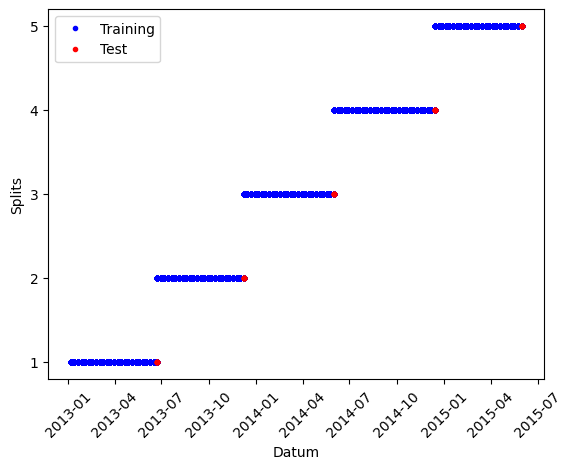

In [ ]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits, test_size=8):
        self.n_splits = n_splits
        self.test_size = test_size
    
    def get_n_splits(self, X, y=None, groups=None):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = stop - self.test_size
            yield indices[start: mid], indices[mid: stop]

# Testen der splits
# Daten
data = df_train_valid.set_index("Datum").sort_index()

# Visualisierung der Splits, test size = 8 Wochen
btscv = BlockingTimeSeriesSplit(n_splits=5, test_size=8)
fig, ax = plt.subplots()

for i, (train_index, test_index) in enumerate(btscv.split(data)):
    ax.plot(data.index[train_index], [i + 1] * len(train_index), 'b.', label='Training' if i == 0 else "")
    ax.plot(data.index[test_index], [i + 1] * len(test_index), 'r.', label='Test' if i == 0 else "")

ax.set_xlabel('Datum')
ax.set_ylabel('Splits')
ax.set_yticks([1, 2, 3, 4, 5])
ax.legend()
plt.xticks(rotation=45)
plt.show()

Zunächst testen wir die Krossvalidierung mit 5 splits. Jedoch könnte es sein, dass die Trainingsdatensätze bei 5 splits zu klein ausfällt und der R2 drastisch fällt.

In [ ]:
rf = RandomForestRegressor(n_jobs=-1)
btscv = BlockingTimeSeriesSplit(n_splits=5)
scores = cross_val_score(rf, X, y, cv=btscv, scoring="r2")
print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))

Loss: 0.796 (+/- 0.169)


Wie erwartet ist der R2 Score gefallen, daher testen wir eine Splitanzahl von 3, damit die Trainingssätze größer sind.

In [ ]:
rf = RandomForestRegressor(n_jobs=-1)
btscv = BlockingTimeSeriesSplit(n_splits=3)
scores = cross_val_score(rf, X, y, cv=btscv, scoring="r2")
print("Loss: {0:.3f} (+/- {1:.3f})".format(scores.mean(), scores.std()))

Loss: 0.952 (+/- 0.025)


Das Modell mit 3 splits schein recht stabil zu sein.

## 4.2. <a id='toc4_2_'></a>Hyperparameter Tuning [&#9650;](#toc0_)

Das Hyperparameter Tuning wird nach Zufall vollzogen. Folgende Paramter werden zufällig ausprobiert.  
1. n_estimators: Die Anzahl der Bäume im Wald. Mehr Bäume können die Genauigkeit verbessern, aber auch die Rechenzeit erhöhen.  

2. max_features: Die Anzahl der Merkmale, die für die Aufteilung eines Knotens in Betracht gezogen werden. Optionen sind:
    - 'sqrt': Wählt die Quadratwurzel der Gesamtzahl der Merkmale.
    - 'log2': Wählt den Logarithmus zur Basis 2 der Gesamtzahl der Merkmale.
3. max_depth: Die maximale Tiefe der Bäume. Eine größere Tiefe kann zu einer besseren Anpassung führen, aber auch das Risiko des Overfittings erhöhen. None bedeutet, dass die Knoten so lange erweitert werden, bis alle Blätter rein sind.  

4. min_samples_split: Die minimale Anzahl von Stichproben, die erforderlich sind, um einen internen Knoten zu teilen. Kleinere Werte können zu einer besseren Anpassung führen, aber auch das Risiko des Overfittings erhöhen.  

5. min_samples_leaf: Die minimale Anzahl von Stichproben, die in einem Blattknoten erforderlich sind. Kleinere Werte können zu einer besseren Anpassung führen, aber auch das Risiko des Overfittings erhöhen.  

6. bootstrap: Ob Bootstrap-Stichproben verwendet werden sollen, wenn Bäume gebaut werden. True bedeutet, dass Bootstrap-Stichproben verwendet werden, False bedeutet, dass die gesamte Stichprobe verwendet wird.

In [ ]:
# Modell und Parameterbereich definieren
model = RandomForestRegressor(n_jobs=-1)
param_dist = {
    'n_estimators': randint(10, 150),
    'max_depth': randint(1, 20),
    'min_samples_split': randint(2, 12),
    'min_samples_leaf': randint(2, 12),
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False]}

btscv = BlockingTimeSeriesSplit(n_splits=5)

# RMSE Scorer definieren
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# RandomizedSearchCV einrichten mit RMSE als Scoring
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=btscv, n_jobs=-1, scoring=rmse_scorer)

# RandomizedSearchCV ausführen
random_search.fit(X, y)

# Ergebnisse sortieren und die Top 5 anzeigen
results = random_search.cv_results_
top5_indices = np.argsort(results['rank_test_score'])[:5]

print("Top 5 Parameterkombinationen und Scores:")
for idx in top5_indices:
    print(f"Parameter: {results['params'][idx]}, Score: {results['mean_test_score'][idx]}")


Top 5 Parameterkombinationen und Scores:
Parameter: {'bootstrap': True, 'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 92}, Score: -0.1067656993296265
Parameter: {'bootstrap': False, 'max_depth': 19, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 84}, Score: -0.10712474910104361
Parameter: {'bootstrap': False, 'max_depth': 17, 'max_features': 'log2', 'min_samples_leaf': 5, 'min_samples_split': 8, 'n_estimators': 82}, Score: -0.1094745217299444
Parameter: {'bootstrap': False, 'max_depth': 18, 'max_features': 'log2', 'min_samples_leaf': 8, 'min_samples_split': 10, 'n_estimators': 83}, Score: -0.10978775261782081
Parameter: {'bootstrap': False, 'max_depth': 19, 'max_features': 'log2', 'min_samples_leaf': 11, 'min_samples_split': 8, 'n_estimators': 45}, Score: -0.11108591493478528


In [ ]:
# (n_estimators=51, max_features="sqrt", max_depth=16, min_samples_split=7, min_samples_leaf=4, bootstrap=True, n_jobs=-1)

Die Paramter werden unten in absteigender Reihenfolge auf Overfitting überprüft.

## 4.3. <a id='toc4_3_'></a>Paramater auf Overfitting testen [&#9650;](#toc0_)

Um auf Overfitting zu prüfen, werden die Metriken für das Tainings- und Test-set verglichen. Wenn der Fehler (RMSE) bei dem Testdatensatz deutlich niedriger ist, könnte das Modell overfittet sein.

In [ ]:
# besten Parameter
# (n_estimators=51, max_features="sqrt", max_depth=16, min_samples_split=7, min_samples_leaf=4, bootstrap=True, n_jobs=-1)

In [ ]:
# Train Daten
X_train = df_train[selected_features]
y_train = df_train['Umsatz']
# Test Daten
X_test = df_valid[selected_features]
y_test = df_valid['Umsatz']

# Modell fitten und prediction
rf = RandomForestRegressor(n_estimators=51, max_features="sqrt", max_depth=16, min_samples_split=7, min_samples_leaf=4, bootstrap=True).fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Metriken berechnen
mae, r2, rmse = metriken(y_test, y_pred_test)
summary1 = pd.DataFrame({"Vergleich": "y_test&y_pred_test", "MAE": [mae], "R2": [r2], "RMSE": [rmse]})
mae, r2, rmse = metriken(y_train, y_pred_train)
summary2 = pd.DataFrame({"Vergleich": "y_train&y_pred_train", "MAE": [mae], "R2": [r2], "RMSE": [rmse]})
summary3 = pd.concat([summary1, summary2])
summary3


,Vergleich,MAE,R2,RMSE
0,y_test&y_pred_test,0.087455,0.907755,0.114010
0,y_train&y_pred_train,0.075741,0.928104,0.103727


Mit einer Differenz von ca. 0.01 (~ 10 %) RMSE auf Trainings- und Validierungs-Datensatz ist das Modell recht stabil und zeigt kein overfitting. Daher wird Modell auf den Trainings-Datensatz ausprobiert.

In [ ]:
# Train Daten
X_train = df_train_valid[selected_features]
y_train = df_train_valid['Umsatz']
# Test Daten
X_test = df_test[selected_features]
y_test = df_test['Umsatz']

# Modell fitten und prediction
rf = RandomForestRegressor(n_estimators=51, max_features="sqrt", max_depth=16, min_samples_split=7, min_samples_leaf=4, bootstrap=True).fit(X_train, y_train)
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Metriken berechnen
mae, r2, rmse = metriken(y_test, y_pred_test)
summary1 = pd.DataFrame({"Vergleich": "y_test&y_pred_test", "MAE": [mae], "R2": [r2], "RMSE": [rmse]})
mae, r2, rmse = metriken(y_train, y_pred_train)
summary2 = pd.DataFrame({"Vergleich": "y_train&y_pred_train", "MAE": [mae], "R2": [r2], "RMSE": [rmse]})
summary3 = pd.concat([summary1, summary2])
summary3


,Vergleich,MAE,R2,RMSE
0,y_test&y_pred_test,0.096777,0.878156,0.124784
0,y_train&y_pred_train,0.075604,0.928683,0.103099


Der RMSE ist etwas gefallen, aber trotzdem sehr gut.

# 5. <a id='toc5_'></a>ZukunftsDataframe erstellen [&#9650;](#toc0_)

## 5.1. <a id='toc5_1_'></a>Datenskelett aufbauen (letzen 8 Wochen der Daten) [&#9650;](#toc0_)

Zunächst wird ein Dataframe mit den selected features für die letzten 8 Wochen der Daten erstellt (2015-06-07 bis 2015-08-02). 

In [ ]:
# Splitten
print(f"Train min {df_train_valid.Datum.min()}")
print(f"Train max {df_train_valid.Datum.max()}")
print(f"Test min {df_test.Datum.min()}")
print(f"Test max {df_test.Datum.max()}")
print(f"Test shape {df_test.shape}")

Train min 2013-01-06 00:00:00
Train max 2015-05-31 00:00:00
Test min 2015-06-07 00:00:00
Test max 2015-08-02 00:00:00
Test shape (10028, 52)


In [ ]:
df_constructed = df_train_valid.copy().sort_values(["Datum", "Filiale"]).reset_index(drop=True)
df_constructed["isFuture"] = False

# Zu erstellender Datenbereich
timestamp = pd.Timestamp(df_weekly["Datum"].sort_values().iloc[-1])
split_point = timestamp - pd.Timedelta(days=(7*8))
# Datum für Skelett erzeugen
skelett_datum = pd.date_range(start=split_point, end=timestamp, freq="W")
skelett_datum = pd.DataFrame({"Datum": skelett_datum})
skelett_datum["isFuture"] = True
skelett_datum["isFuture"] = skelett_datum["isFuture"].astype(bool)

# Filiale in skelett einfügen
df_list = []
# Für jeden Filiale in future extra 8 wochen erzeugen
for Filiale in df_constructed['Filiale'].unique():
    # Füge die Filiale-Information zu future_df hinzu
    skelett_filiale = skelett_datum.copy()
    skelett_filiale['Filiale'] = Filiale
    # Füge den DataFrame zur Liste hinzu
    df_list.append(skelett_filiale)

# Skelett Filiale und Datum vereinigen    
skelett = pd.concat(df_list)
skelett = skelett.sort_values(["Datum", "Filiale"])

# zusätzliche Spalten i, selbst konstruierten dataframe finden 
extra_rows = skelett[~skelett.set_index(['Datum', 'Filiale']).index.isin(df_test.set_index(['Datum', 'Filiale']).index)]
# Entferne die zusätzlichen Zeilen
skelett = skelett[~skelett[['Datum', 'Filiale']].apply(tuple, axis=1).isin(extra_rows[['Datum', 'Filiale']].apply(tuple, axis=1))]

print(f"skelett min    {skelett.Datum.min()}")
print(f"skelett max    {skelett.Datum.max()}")
print(f"skelett shape  {skelett.shape}")

# Skelett an original df anfügen mit Feiertag bereits aufgespalten
df_constructed = pd.concat([df_constructed, skelett]).sort_values(["Filiale", "Datum"]).reset_index(drop=True)

skelett min    2015-06-07 00:00:00
skelett max    2015-08-02 00:00:00
skelett shape  (10028, 3)


Nachdem das Gerüst mit den Daten und Filialen nun steht, müssen die ausgewählten Features für das Zeitfenster imputiert werden.  

In [ ]:
# statische Infos, einfach auffüllen
to_original = ['Filiale']
to_ffill = ['Gruppe',  'Promo2_seit_Woche',
            'Wettbew_offen_seit_Monat', 'Wettbew_offen_seit_Jahr', 'Wettbew_Distanz']
# mit Feature engineering erstellen
to_feature = ['Wettbew_seit_Monaten', 'Promo2_seit_Wochen']
# Vom Datum ableiten
to_datum = ['Kalenderwoche', 'Kalenderwoche_cos']
# Aus eda gewonnenen Erkenntnissen
to_manuell = ['Promo']

In [ ]:
# Imputieren
# ffill methode
# Wettbew_Distanz
for feature in to_ffill:
    for i in df_constructed.Filiale.unique():
        df_constructed.loc[df_constructed['Filiale'] == i, feature] = \
            df_constructed.loc[df_constructed['Filiale'] == i, feature].ffill()

# Kalenderwoche
df_constructed['Kalenderwoche'] = df_constructed['Kalenderwoche'].fillna(df_constructed.Datum.dt.isocalendar().week)
df_constructed['Kalenderwoche_cos'] = df_constructed['Kalenderwoche'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# Wettbew_offen_seit_Monaten
df_constructed.Wettbew_offen_seit_Jahr = df_constructed.Wettbew_offen_seit_Jahr.astype("float64")
df_constructed.Wettbew_offen_seit_Monat = df_constructed.Wettbew_offen_seit_Monat.astype("float64")
df_constructed['Wettbew_seit'] = df_constructed.apply(lambda x: datetime(year = int(x['Wettbew_offen_seit_Jahr']),
                                                                         month = int(x['Wettbew_offen_seit_Monat']),
                                                                         day = 1),
                                                      axis = 1)
df_constructed['Wettbew_seit_Monaten'] = ((df_constructed['Datum'] - df_constructed['Wettbew_seit']) / 30).apply(lambda x: x.days).astype(int)

# Promo2_seit_Wochen
# Promo2_seit_Jahr
for i in df_constructed.Filiale.unique():
    df_constructed.loc[df_constructed['Filiale'] == i, "Promo2_seit_Jahr"] = \
        df_constructed.loc[df_constructed['Filiale'] == i, "Promo2_seit_Jahr"].ffill()        
df_constructed['Promo2_seit'] = np.where(df_constructed['Promo2_seit_Jahr'] != 0,
                                   (df_constructed['Promo2_seit_Jahr']).astype(int).astype(str) + '-' + (df_constructed['Promo2_seit_Woche']).astype(int).astype(str),
                                   "2020-01")
df_constructed['Promo2_seit'] = df_constructed['Promo2_seit'].apply(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))
# Berechne Promo2_seit_Wochen --> Promo2_seit vom aktuellen Datum subtrahieren
df_constructed['Promo2_seit_Wochen'] = np.where(df_constructed['Promo2_seit'] != "2019-12-30",
                                          round((df_constructed['Datum'] - df_constructed['Promo2_seit']) / np.timedelta64(1, "W")).astype(int),
                                          0)


# Promo --> Fehler von 6.91 %
while df_constructed["Promo"].isna().any():
    for i in df_constructed.Filiale.unique():
        df_constructed["Promo"] = df_constructed["Promo"].fillna(df_constructed["Promo"].shift(2))

# Promo --> auf diese Weise Fehler von 17.94 %
# (Wochen: 1, 7, 9, 11, 24, 26, 28, 30, 31, 32, 42, 44, 50)
# df_constructed["Promo"] = np.where((df_constructed.Datum.dt.isocalendar().week == 1) | (df_constructed.Datum.dt.isocalendar().week == 7) | (df_constructed.Datum.dt.isocalendar().week == 9) |
#                                     (df_constructed.Datum.dt.isocalendar().week == 11) | (df_constructed.Datum.dt.isocalendar().week == 24) | (df_constructed.Datum.dt.isocalendar().week == 26) |
#                                     (df_constructed.Datum.dt.isocalendar().week == 28) | (df_constructed.Datum.dt.isocalendar().week == 30) | (df_constructed.Datum.dt.isocalendar().week == 31) | 
#                                     (df_constructed.Datum.dt.isocalendar().week == 32) | (df_constructed.Datum.dt.isocalendar().week == 42) | (df_constructed.Datum.dt.isocalendar().week == 44) | 
#                                     (df_constructed.Datum.dt.isocalendar().week == 50), 0, 5 )

df_constructed = df_constructed.loc[df_constructed["isFuture"] == True]
df_constructed = df_constructed[selected_features + ["Datum"]]
print(f"df_constructed shape: {df_constructed.shape}")
df_constructed.head()

df_constructed shape: (10028, 12)


,Gruppe,Promo,Wettbew_Distanz,Filiale,Kalenderwoche,Wettbew_seit_Monaten,Wettbew_offen_seit_Monat,Promo2_seit_Wochen,Promo2_seit_Woche,Wettbew_offen_seit_Jahr,Kalenderwoche_cos,Datum
126,2.0,5.0,1270.0,1,23,82,9.0,0,0.0,2008.0,-0.935016,2015-06-07
127,2.0,0.0,1270.0,1,24,82,9.0,0,0.0,2008.0,-0.970942,2015-06-14
128,2.0,5.0,1270.0,1,25,82,9.0,0,0.0,2008.0,-0.992709,2015-06-21
129,2.0,0.0,1270.0,1,26,83,9.0,0,0.0,2008.0,-1.000000,2015-06-28
130,2.0,5.0,1270.0,1,27,83,9.0,0,0.0,2008.0,-0.992709,2015-07-05


In [ ]:
df_constructed.isna().any().sum()

0

Nun vergleichen wie gut df_test und df_constructed übereinstimmen

In [ ]:
# Unterschiede in den einzelnen Spalten zwischen df_test und df_constructed
for feature in selected_features + ["Datum"]:   
    anzahl_unterschiede = []
    for filiale in df_constructed['Filiale'].unique():
        df1 = df_constructed.loc[df_constructed['Filiale'] == filiale, [feature]].reset_index(drop=True).sort_index(axis=1)
        df2 = df_test.loc[df_test['Filiale'] == filiale, [feature]].reset_index(drop=True).sort_index(axis=1)
        comparison = df1.compare(df2)
        if not comparison.empty:
            anzahl_unterschiede.append(comparison.shape[0])
    print(f"Anteil falscher Werte {feature} {round(np.sum(anzahl_unterschiede) / df_constructed.shape[0] * 100, 2)} %")

Anteil falscher Werte Gruppe 0.0 %
Anteil falscher Werte Promo 6.91 %
Anteil falscher Werte Wettbew_Distanz 0.0 %
Anteil falscher Werte Filiale 0.0 %
Anteil falscher Werte Kalenderwoche 0.0 %
Anteil falscher Werte Wettbew_seit_Monaten 3.78 %
Anteil falscher Werte Wettbew_offen_seit_Monat 0.0 %
Anteil falscher Werte Promo2_seit_Wochen 0.02 %
Anteil falscher Werte Promo2_seit_Woche 0.0 %
Anteil falscher Werte Wettbew_offen_seit_Jahr 0.0 %
Anteil falscher Werte Kalenderwoche_cos 0.0 %
Anteil falscher Werte Datum 0.0 %


Insgesamt wurden 6.91 %  Werte in Promo falsch imputiert.
Der Unterschied ist durch die Daten nicht erklärbar.

In [ ]:
df_test[df_test.Promo == 4]

,Filiale,Datum,Umsatz,Geöffnet,Promo,ist_Promo2,Schulferien,Ostern,Weihnachten,öffentl_Feiertag,regulärer_Tag,Sonntag,Gruppe,Wettbew_Distanz,Wettbew_seit_Monaten,Wettbew_offen_seit_Monat,Wettbew_offen_seit_Jahr,Promo2,Promo2_seit_Wochen,Promo2_seit_Woche,Promo2_seit_Jahr,Jahr,Quartal,Monat,Kalenderwoche,Geschäftstyp_a,Geschäftstyp_b,Geschäftstyp_c,Geschäftstyp_d,Sortiment_basic,Sortiment_extended,Sortiment_extra,Bundesland_Baden_Württemberg,Bundesland_Bayern,Bundesland_Berlin,Bundesland_Bremen,Bundesland_Hamburg,Bundesland_Hessen,Bundesland_NRW,Bundesland_Rheinland_Pfalz,Bundesland_Sachsen,Bundesland_Sachsen_Anhalt,Bundesland_Schleswig_Holstein,Bundesland_Thüringen,Quartal_sin,Quartal_cos,Monat_sin,Monat_cos,Kalenderwoche_sin,Kalenderwoche_cos,Jahr_sin,Jahr_cos
0,1,2015-06-07,10.188666,5,4,0,0,0.0,0.0,0.0,5.0,0,2,1270.0,82.0,9.0,2008.0,0.0,0.0,0.0,0.0,2015.0,2.0,6.0,23,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.224647e-16,-1.0,1.224647e-16,-1.0,0.354605,-0.935016,-0.128748,-0.991677
2,3,2015-06-07,10.735222,5,4,0,0,0.0,0.0,0.0,5.0,0,3,14130.0,103.0,12.0,2006.0,1.0,219.0,14.0,2011.0,2015.0,2.0,6.0,23,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.224647e-16,-1.0,1.224647e-16,-1.0,0.354605,-0.935016,-0.128748,-0.991677
8,9,2015-06-07,10.807746,5,4,0,0,0.0,0.0,0.0,5.0,0,3,2030.0,180.0,8.0,2000.0,0.0,0.0,0.0,0.0,2015.0,2.0,6.0,23,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.224647e-16,-1.0,1.224647e-16,-1.0,0.354605,-0.935016,-0.128748,-0.991677
12,13,2015-06-07,10.295057,5,4,0,4,0.0,0.0,0.0,5.0,0,1,310.0,146.0,6.0,2003.0,1.0,292.0,45.0,2009.0,2015.0,2.0,6.0,23,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.224647e-16,-1.0,1.224647e-16,-1.0,0.354605,-0.935016,-0.128748,-0.991677
13,14,2015-06-07,10.403505,5,4,0,0,0.0,0.0,0.0,5.0,0,2,1300.0,15.0,3.0,2014.0,1.0,193.0,40.0,2011.0,2015.0,2.0,6.0,23,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.224647e-16,-1.0,1.224647e-16,-1.0,0.354605,-0.935016,-0.128748,-0.991677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,1107,2015-06-07,10.613148,5,4,0,4,0.0,0.0,0.0,5.0,0,2,1400.0,36.0,6.0,2012.0,1.0,272.0,13.0,2010.0,2015.0,2.0,6.0,23,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.224647e-16,-1.0,1.224647e-16,-1.0,0.354605,-0.935016,-0.128748,-0.991677
1108,1109,2015-06-07,10.301928,5,4,0,4,0.0,0.0,0.0,5.0,0,1,3490.0,50.0,4.0,2011.0,1.0,159.0,22.0,2012.0,2015.0,2.0,6.0,23,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.224647e-16,-1.0,1.224647e-16,-1.0,0.354605,-0.935016,-0.128748,-0.991677
1110,1111,2015-06-07,10.292078,5,4,0,0,0.0,0.0,0.0,5.0,0,2,1900.0,12.0,6.0,2014.0,1.0,97.0,31.0,2013.0,2015.0,2.0,6.0,23,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.224647e-16,-1.0,1.224647e-16,-1.0,0.354605,-0.935016,-0.128748,-0.991677
1111,1112,2015-06-07,11.066638,5,4,0,0,0.0,0.0,0.0,5.0,0,4,1880.0,111.0,4.0,2006.0,0.0,0.0,0.0,0.0,2015.0,2.0,6.0,23,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.224647e-16,-1.0,1.224647e-16,-1.0,0.354605,-0.935016,-0.128748,-0.991677


## 5.2. <a id='toc5_2_'></a>Datenskelett testen [&#9650;](#toc0_)

Zunächst den Transformer anpassen um auch df_constructed zu transformieren

In [ ]:
print(f"df_train_valid min         {df_train_valid.Datum.min()}")
print(f"df_train_valid max         {df_train_valid.Datum.max()}")
print(f"df_train_valid shape       {df_train_valid.shape}")
print("")
print(f"df_test min          {df_test.Datum.min()}")
print(f"df_test max          {df_test.Datum.max()}")
print(f"df_test shape        {df_test.shape}")
print("")
print(f"df_constructed min   {df_constructed.Datum.min()}")
print(f"df_constructed max   {df_constructed.Datum.max()}")
print(f"df_constructed shape {df_constructed.shape}")

df_test.sort_values(["Datum", "Filiale"], inplace=True)
df_constructed.sort_values(["Datum", "Filiale"], inplace=True)
# Train Daten
X_train = df_train_valid[selected_features]
y_train = df_train_valid['Umsatz']
# Test Daten
X_test = df_test[selected_features]
y_test = df_test['Umsatz']
# Konstruierte Daten
X_test_constr = df_constructed[selected_features]

# Modell fitten und prediction
rf = RandomForestRegressor(n_estimators=51, max_features="sqrt", max_depth=16, min_samples_split=7, min_samples_leaf=4, bootstrap=True).fit(X_train, y_train)

# Vorhersage Testdaten
y_pred_test = rf.predict(X_test)
# Metriken berechnen
mae, r2, rmse = metriken(y_test, y_pred_test)
y_pred_test_results = pd.DataFrame({"Vergleich": ["y_test/y_pred_test"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})

# Vorhersage imputierte Daten
y_pred_constr = rf.predict(X_test_constr)
mae, r2, rmse = metriken(y_test, y_pred_constr)
y_pred_constr_results = pd.DataFrame({"Vergleich": ["y_test/y_pred_constr"], "MAE": [mae], "R2": [r2], "RMSE": [rmse]})
# Ergebnisse speichern
results_imputation = pd.concat([y_pred_test_results, y_pred_constr_results])
results_imputation.set_index("Vergleich")

df_train_valid min         2013-01-06 00:00:00
df_train_valid max         2015-05-31 00:00:00
df_train_valid shape       (135780, 52)

df_test min          2015-06-07 00:00:00
df_test max          2015-08-02 00:00:00
df_test shape        (10028, 52)

df_constructed min   2015-06-07 00:00:00
df_constructed max   2015-08-02 00:00:00
df_constructed shape (10028, 12)


,MAE,R2,RMSE
Vergleich,,,
y_test/y_pred_test,0.097486,0.875685,0.126043
y_test/y_pred_constr,0.097891,0.873776,0.127006


Das Modell sagt den Umsatz basierend auf einem konstruierten Dataframe sehr gut voraus.

# 6. <a id='toc6_'></a>Finales Modell und Zukunft [&#9650;](#toc0_)

## 6.1. <a id='toc6_1_'></a>Datenskelett aufbauen (zukunft) [&#9650;](#toc0_)

Zunächst wird ein Dataframe mit den selected features für die Zukunft erstellt (2015-08.03 bis 2015-09-27). 

In [ ]:
df_constructed = df_train_valid.copy().sort_values(["Datum", "Filiale"]).reset_index(drop=True)
df_constructed["isFuture"] = False

# Zu erstellender Datenbereich
timestamp = pd.Timestamp(df["Datum"].sort_values().iloc[-1])
split_point = timestamp - pd.Timedelta(days=(7*8))
# Datum für Skelett erzeugen
skelett_datum = pd.date_range(start=split_point, end=timestamp, freq="W")
skelett_datum = pd.DataFrame({"Datum": skelett_datum})
skelett_datum["isFuture"] = True
skelett_datum["isFuture"] = skelett_datum["isFuture"].astype(bool)

# Filiale in skelett einfügen
df_list = []
# Für jeden Filiale in future extra 8 wochen erzeugen
for Filiale in df_constructed['Filiale'].unique():
    # Füge die Filiale-Information zu future_df hinzu
    skelett_filiale = skelett_datum.copy()
    skelett_filiale['Filiale'] = Filiale
    # Füge den DataFrame zur Liste hinzu
    df_list.append(skelett_filiale)

# Skelett Filiale und Datum vereinigen    
skelett = pd.concat(df_list)
skelett = skelett.sort_values(["Datum", "Filiale"])

# zusätzliche Spalten i, selbst konstruierten dataframe finden 
extra_rows = skelett[~skelett.set_index(['Datum', 'Filiale']).index.isin(df_test.set_index(['Datum', 'Filiale']).index)]
# Entferne die zusätzlichen Zeilen
skelett = skelett[~skelett[['Datum', 'Filiale']].apply(tuple, axis=1).isin(extra_rows[['Datum', 'Filiale']].apply(tuple, axis=1))]

print(f"skelett min    {skelett.Datum.min()}")
print(f"skelett max    {skelett.Datum.max()}")
print(f"skelett shape  {skelett.shape}")

# Skelett an original df anfügen mit Feiertag bereits aufgespalten
df_constructed = pd.concat([df_constructed, skelett]).sort_values(["Filiale", "Datum"]).reset_index(drop=True)

skelett min    2015-06-07 00:00:00
skelett max    2015-08-02 00:00:00
skelett shape  (10028, 3)


In [ ]:
df_constructed = df.copy().sort_values(["Datum", "Filiale"]).reset_index(drop=True)
df_constructed["isFuture"] = False

# Zu erstellender Datenbereich
timestamp = pd.Timestamp(df["Datum"].sort_values().iloc[-1]) + pd.Timedelta(days=(1))
end_point = timestamp + pd.Timedelta(days=(7*8))
# Datum für Skelett erzeugen
skelett_datum = pd.date_range(start=timestamp, end=end_point, freq="W")
skelett_datum = pd.DataFrame({"Datum": skelett_datum})
skelett_datum["isFuture"] = True
skelett_datum["isFuture"] = skelett_datum["isFuture"].astype(bool)

# Filiale in skelett einfügen
df_list = []
# Für jeden Filiale in future extra 8 wochen erzeugen
for Filiale in df_constructed['Filiale'].unique():
    # Füge die Filiale-Information zu future_df hinzu
    skelett_filiale = skelett_datum.copy()
    skelett_filiale['Filiale'] = Filiale
    # Füge den DataFrame zur Liste hinzu
    df_list.append(skelett_filiale)

# Skelett Filiale und Datum vereinigen    
skelett = pd.concat(df_list)
skelett = skelett.sort_values(["Datum", "Filiale"])

print(f"skelett min    {skelett.Datum.min()}")
print(f"skelett max    {skelett.Datum.max()}")
print(f"skelett shape  {skelett.shape}")

# Skelett an original df anfügen mit Feiertag bereits aufgespalten
df_constructed = pd.concat([df_constructed, skelett]).sort_values(["Filiale", "Datum"]).reset_index(drop=True)

skelett min    2015-08-09 00:00:00
skelett max    2015-09-27 00:00:00
skelett shape  (8920, 3)


In [ ]:
skelett_filiale

,Datum,isFuture,Filiale
0,2015-08-09,True,1081
1,2015-08-16,True,1081
2,2015-08-23,True,1081
3,2015-08-30,True,1081
4,2015-09-06,True,1081
5,2015-09-13,True,1081
6,2015-09-20,True,1081
7,2015-09-27,True,1081


Nachdem das Gerüst mit den Daten und Filialen nun steht, wird wieder imputiert

In [ ]:
# Imputieren
# ffill methode
# Wettbew_Distanz
for feature in to_ffill:
    for i in df_constructed.Filiale.unique():
        df_constructed.loc[df_constructed['Filiale'] == i, feature] = \
            df_constructed.loc[df_constructed['Filiale'] == i, feature].ffill()

# Kalenderwoche
df_constructed['Kalenderwoche'] = df_constructed['Kalenderwoche'].fillna(df_constructed.Datum.dt.isocalendar().week)
df_constructed['Kalenderwoche_cos'] = df_constructed['Kalenderwoche'].apply(lambda x: np.cos(x*(2*np.pi/52)))

# Wettbew_offen_seit_Monaten
df_constructed.Wettbew_offen_seit_Jahr = df_constructed.Wettbew_offen_seit_Jahr.astype("float64")
df_constructed.Wettbew_offen_seit_Monat = df_constructed.Wettbew_offen_seit_Monat.astype("float64")
df_constructed['Wettbew_seit'] = df_constructed.apply(lambda x: datetime(year = int(x['Wettbew_offen_seit_Jahr']),
                                                                         month = int(x['Wettbew_offen_seit_Monat']),
                                                                         day = 1),
                                                      axis = 1)
df_constructed['Wettbew_seit_Monaten'] = ((df_constructed['Datum'] - df_constructed['Wettbew_seit']) / 30).apply(lambda x: x.days).astype(int)

# Promo2_seit_Wochen
# Promo2_seit_Jahr
for i in df_constructed.Filiale.unique():
    df_constructed.loc[df_constructed['Filiale'] == i, "Promo2_seit_Jahr"] = \
        df_constructed.loc[df_constructed['Filiale'] == i, "Promo2_seit_Jahr"].ffill()        
df_constructed['Promo2_seit'] = np.where(df_constructed['Promo2_seit_Jahr'] != 0,
                                   (df_constructed['Promo2_seit_Jahr']).astype(int).astype(str) + '-' + (df_constructed['Promo2_seit_Woche']).astype(int).astype(str),
                                   "2020-01")
df_constructed['Promo2_seit'] = df_constructed['Promo2_seit'].apply(lambda x: datetime.strptime(x + '-1', '%Y-%W-%w') - timedelta(days=7))
# Berechne Promo2_seit_Wochen --> Promo2_seit vom aktuellen Datum subtrahieren
df_constructed['Promo2_seit_Wochen'] = np.where(df_constructed['Promo2_seit'] != "2019-12-30",
                                          round((df_constructed['Datum'] - df_constructed['Promo2_seit']) / np.timedelta64(1, "W")).astype(int),
                                          0)


# Promo --> Fehler von 6.91 %
while df_constructed["Promo"].isna().any():
    for i in df_constructed.Filiale.unique():
        df_constructed["Promo"] = df_constructed["Promo"].fillna(df_constructed["Promo"].shift(2))

df_constructed = df_constructed.loc[df_constructed["isFuture"] == True]
df_constructed = df_constructed[selected_features + ["Datum"]]
print(f"df_constructed shape: {df_constructed.shape}")
df_constructed.head()

df_constructed shape: (8920, 12)


,Gruppe,Promo,Wettbew_Distanz,Filiale,Kalenderwoche,Wettbew_seit_Monaten,Wettbew_offen_seit_Monat,Promo2_seit_Wochen,Promo2_seit_Woche,Wettbew_offen_seit_Jahr,Kalenderwoche_cos,Datum
135,2.0,0.0,1270.0,1,32,84,9.0,0,0.0,2008.0,-0.748511,2015-08-09
136,2.0,5.0,1270.0,1,33,84,9.0,0,0.0,2008.0,-0.663123,2015-08-16
137,2.0,0.0,1270.0,1,34,84,9.0,0,0.0,2008.0,-0.568065,2015-08-23
138,2.0,5.0,1270.0,1,35,85,9.0,0,0.0,2008.0,-0.464723,2015-08-30
139,2.0,0.0,1270.0,1,36,85,9.0,0,0.0,2008.0,-0.354605,2015-09-06


In [ ]:
df_constructed.isna().sum()

Gruppe                      0
Promo                       0
Wettbew_Distanz             0
Filiale                     0
Kalenderwoche               0
Wettbew_seit_Monaten        0
Wettbew_offen_seit_Monat    0
Promo2_seit_Wochen          0
Promo2_seit_Woche           0
Wettbew_offen_seit_Jahr     0
Kalenderwoche_cos           0
Datum                       0
dtype: int64

## 6.2. <a id='toc6_2_'></a>Zukunft vorhersagen [&#9650;](#toc0_)

Transformations-Funktion wird erneut angepasst

In [ ]:
df.sort_values(["Datum", "Filiale"], inplace=True)
df_constructed.sort_values(["Datum", "Filiale"], inplace=True)
df_constructed.reset_index(inplace=True, drop=True)

# Train Daten
X_train = df[selected_features]
y_train = df['Umsatz']
# Test Daten
X_test = df_constructed[selected_features]

# Modell fitten und prediction
rf = RandomForestRegressor(n_estimators=51, max_features="sqrt", max_depth=16, min_samples_split=7, min_samples_leaf=4, bootstrap=True).fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [ ]:
df_vorhersage = df_constructed[["Datum", "Filiale"]].copy()
df_vorhersage.sort_values(["Datum", "Filiale"], inplace=True)

# Rücktransformation der logarithmierten Werte
y_past = np.exp(y_train).astype(int).copy()
y_future = np.exp(y_pred).astype(int).copy()
y_rücktransformiert_df = pd.DataFrame({"Umsatz_pred": y_future})

df_vorhersage = pd.concat([df_vorhersage, y_rücktransformiert_df], axis=1)
df_vorhersage = df_vorhersage.groupby(["Datum"])["Umsatz_pred"].sum().reset_index()
# Plotly Express Plot
fig = px.line(df_vorhersage, x='Datum', y="Umsatz_pred",
              title='Umsatz Vorhersage für die nächsten 8 Wochen 09.08. - 27.09.2015', labels={"Umsatz_pred": "Gesamtumsatz [€]"})
fig.show()

für den Zeitraum 2015-08-02 bis 2015-09-20 wird 348.597.521 € vorhergesagt.

In [ ]:
df_vorhersage.Umsatz_pred.sum()

348989590

In [ ]:
# train unf future speichern
df_weekly.to_parquet("..\\Save_files\\df_data.parquet", engine='pyarrow')
df.to_parquet("..\\Save_files\\df_transformed_data.parquet", engine='pyarrow')
df_constructed.to_parquet("..\\Save_files\\df_future_construct.parquet", engine='pyarrow')
# Modell speichern
joblib.dump(rf,"..\\MachineLearning_Modell\\random_forest_model.joblib", compress=3)




['..\\MachineLearning_Modell\\random_forest_model.joblib']